# 二. k近邻算法

k近邻法(`k-nearest neighbor, k-NN`)是一种基本分类和回归方法(`Cover & Hart, 1968`)。k近邻法的输入为实例的特征向量，对应于特征空间的点，输出为实例的类别，可以取多类。分类时，对新的实例，根据其k个最近邻的训练实例的类别，根据其k个最近邻的训练实例的类别，通过多数表决等方式进行预测。

k近邻法不具显式的学习过程，k值的选择、距离度量以及分类决策规则是k近邻法的三要素。难点在于如何高效地定位到输入实例的k个最近邻居。

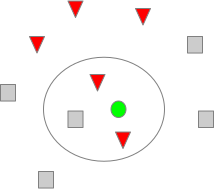

In [3]:
from IPython.display import SVG
SVG(filename='../pictures/3.1.svg')

## 1. k近邻算法

**算法3.1（k近邻法）**
- 输入：训练数据集
$$
T=\{(x_1, y_1), (x_2, y_2), ..., (x_N, y_N)\}
$$
其中，$x_i\in\mathbf{x}\subset \mathbf{R^n}$为实例的特征向量，$y_i\in \mathbf{y}=\{c_1,c_2,...,c_K\}$为实例的类别，$i=1,2,...,N$；实例特征向量$x$；
- 输出：实例$x$的所属类$y$
- 算法过程
    - 根据给定的距离度量，在训练集$T$中找出与$x$最近邻的$k$个点，涵盖这$k$个点的$x$的近邻记作$N_K(x)$
    - 在$N_k(x)$中根据分类决策规则决定$x$类别$y$
    $$
    y=\mathrm{arg} \max_{c_j} \sum_{x_i\in N_k(x)} I(y_i=c_i),i=1,2,...,N;j=1,2,...,K
    $$
    上式中，I为指示函数，即当$y_i=c_j$时$I$为1，否则$I$为0.

## 2. 距离度量

- $L_p$距离

设特征空间$\mathbf{X}$是n维实数向量空间$\mathbf{R^n}$，$x_i, x_j\in \mathbf{x}, x_i = (x^{(1)}_i,x^{(2)}_i,...,x^{(n)}_i)^T,x_j=(x_j^{(1)}, x_j^{(2)},... ,x_j^{(n)})^T,x_i,x_j$的$L_p$距离定义为
$$
L_p(x_i,x_j)=\left(\sum_{l=1}^n|x_i^{(l)}-x_j^{(l)}|^p\right)^{\frac{1}{p}}
$$
这里$p\ge 1$。

当$p=2$时，称为欧式距离(`Euclidean distance`)，即
$$
L_2(x_i,x_j)=\left(\sum_{l=1}^n|x_i^{(l)}-x_j^{(l)}|^2\right)^{\frac{1}{2}}
$$

当$p=1$时，称为曼哈顿距离(`Manhattan distance`)，即
$$
L_1(x_i,x_j)=\left(\sum_{l=1}^n|x_i^{(l)}-x_j^{(l)}|\right)
$$

当$p=\infty$时，它是各个坐标距离的最大值，即
$$
L_{\infty}(x_i,x_j)=\max_l|x_i^{(l)}-x_j^{(l)}|
$$

In [4]:
import numpy as np
import pandas as pd
import networkx as nx
import time

In [5]:
def distance(xi, xj, p=2):
    if np.isinf(p):
        return np.max(np.abs(xi - xj))
    else:
        return np.sum((np.abs(xi - xj))**p)**(1/p)

In [6]:
x1 = np.array([1,2,3])
x2 = np.array([3,2,1])

In [7]:
distance(x1, x2, p=1)

4.0

- 线性搜索

In [8]:
def line_search_knn(x, X, k):
    dist_list = []
    for i in range(len(X)):
        dist_list.append([distance(X[i], x), i])
        
    top_k = sorted(dist_list)[:k]
    return top_k

## 3. `kd`树

### 3.1 构造`kd`树

注意，kd树是存储k维空间数据的树结构，这里的k与k近邻中的的k意义不同。通常，依次选择坐标轴对空间划分，选择训练实例点在选定坐标轴上的中位数为切分点，这样得到的kd树是平衡的。

kd树是一种对k维空间中的实例点进行存储以便对其进行快速检索的树型数据结构。kd树是二叉树，表示对k维空间的一个划分。构造kd树相当于不断地用垂直于坐标轴的超平面将k维空间切分，构成一系列的k维超矩形区域。

kd树的每一个结点对应于一个k维矩形区域。

**算法3.2（构造平衡kd数）**
- 输入：k维空间数据集$T=\{(x_1, y_1), (x_2, y_2), ..., (x_N, y_N)\}$，其中$x_i = (x^{(1)}_i,x^{(2)}_i,...,x^{(n)}_i)^T,i=1,2,...,N$
- 输出：kd平衡树
- 算法过程：
    - 开始：构造根结点，根结点对应于包含T的k维空间的超矩形区域。选择以$x^{(1)}$为坐标轴，以T中所有实例的$x^{(1)}$坐标的*中位数*为切分点，将根结点对应的超矩形区域切分成两个子区域。切分由通过切分点并与坐标轴$x^{(1)}$垂直的超平面实现。由根结点生成深度为1的左右子结点：左子区域对应$x^{(1)}$小于切分点的子区域，右子区域对应$x^{(1)}$大于切分点的子区域。将落在切分超平面上的实例点保存在根结点。
    - 重复：对深度为j的结点，选择$x^{(l)}$为切分的坐标轴，$l=(j\ \text{mod}\ k) + 1$，以该节点的区域所有实例的$x^{(1)}$坐标的中位数为切分点，将该结点对应的超矩形区域切分为两个子区域。切分由通过切分点并与坐标轴$x^{(j)}$垂直的超平面实现。由根结点生成深度为$j+1$的左右子结点：左子区域对应$x^{(l)}$小于切分点的子区域，右子区域对应$x^{(l)}$大于切分点的子区域。将落在切分超平面上的实例点保存在该结点。
    - 直到两个区域没有实例存在时停止。从而形成kd树的区域划分。
 

问题：
- 如果使用中位数作为切分点，非叶结点上可能没有数据，如何处理？
- 多个数据保留在非叶结点上，如何处理？
- 倒数第二层只有2个结点，继续分时缺少右子结点，如何继续往下分？

#### 3.1.1. 基于递归生成kd树

结点如何生长？
- 如果结点对应数据个数不大于1，则停止增长
- 如果结点对应数据个数大于1，则继续生成两个后代结点
    - 按照指定维度的数据切分为两部分，下分给两个后代节点

可以利用递归思想生成kd树。

In [9]:
def generate_node_id(start=0, step=1):
    '''
    用于生成结点编号
    '''
    node_id = start
    while True:
        yield node_id
        node_id += step

In [43]:
def gen_kdTree_recur(X, y, dim, node_id=0, kd_tree=nx.DiGraph()):
    '''
    X: ndarray
    y: ndarray
    k: 实例的维度
    dim: 当前结点所处的维度
    node_id: 当前结点的编号
    '''
    k = X.shape[1]
    if node_id == 0:  # 根结点
        kd_tree.add_node(node_id)
        
    if y.size >= 2:  # 如果有两个以上的结点，继续往下分
        x_dim = X[:, dim]  # 取当前维度数据
        next_dim = (dim + 1) % k  # 获取下一代结点数据的切分维度
        s_indices = np.argsort(x_dim)  # 获取按x_dim由小到大排序的各特征索引
        m = len(s_indices) // 2  # 中间或中间靠左的索引
        l_indices = s_indices[:m]  # 左子区域索引
        m_idx = s_indices[m]  # 留在结点上的数据索引
        r_indices = s_indices[m + 1:]  # 右子区域索引
        l_X, l_y = X[l_indices], y[l_indices]
        r_X, r_y = X[r_indices], y[r_indices]
        l_node_id = next(nodeId_gen)  # 获取下一个结点编号
        r_node_id = next(nodeId_gen)
        # 添加当前结点到子节点的连边
        kd_tree.add_edges_from([(node_id, l_node_id), (node_id, r_node_id)])  
        kd_tree.nodes[node_id]["l_succ"] = l_node_id
        kd_tree.nodes[node_id]["r_succ"] = r_node_id
        kd_tree.nodes[node_id]["dim"] = dim  # 结点的切分维度
        kd_tree.nodes[node_id]["point"] = (X[m_idx], y[m_idx])  # 当前结点上的数据
        kd_tree = gen_kdTree_recur(l_X, l_y, next_dim, l_node_id, kd_tree)  # 递归左子结点
        kd_tree = gen_kdTree_recur(r_X, r_y, next_dim, r_node_id, kd_tree)  # 递归左子结点
    else:  # 如果少于2个结点，则将当前结点设为叶结点
        kd_tree.nodes[node_id]['node_type'] = 'leaf'
        if y.size == 1:
            kd_tree.nodes[node_id]["dim"] = dim  # 结点的继续切分维度
            kd_tree.nodes[node_id]["point"] = (X[0], y[0])
        else:
            p_node_id = list(kd_tree.predecessors(node_id))[0]
            # 有些叶结点可能没有数据，为了简化接下来的搜索程序，该结点取父结点的数据
            kd_tree.nodes[node_id]["dim"] = kd_tree.nodes[p_node_id]["dim"]
            kd_tree.nodes[node_id]["point"] = kd_tree.nodes[p_node_id]["point"]
            
    return kd_tree

In [149]:
X = np.random.randint(low=0, high=100, size=(10000, 6))
y = np.ones(X.shape[0], dtype=np.int)
y[np.random.rand(y.size) < 0.5] = 0
dim = 0
nodeId_gen = generate_node_id(start=0)  # 用于生成结点编号
root_nodeId = next(nodeId_gen)
tree = gen_kdTree_recur(X, y, dim=0, node_id=root_nodeId, kd_tree=nx.DiGraph())

In [150]:
tree.number_of_nodes()

11809

#### 3.1.2 基于循环生成kd树

In [157]:
np.var(X, axis=0)

array([826.46412711, 829.637416  , 821.16706559, 840.14654591,
       822.18911616, 832.71842831])

In [158]:
X[:10]

array([[46, 81, 16, 55, 83, 13],
       [26, 23, 85,  8, 79, 71],
       [95, 14, 64, 88, 24,  1],
       [46, 37, 29,  8, 95, 52],
       [15, 60, 67, 65, 35, 79],
       [54, 59, 44, 57, 65, 29],
       [63, 49, 67, 45,  7, 97],
       [77, 73, 50, 67, 25, 89],
       [23, 82, 97, 61, 75,  6],
       [89, 82, 76, 76, 52,  4]])

In [13]:
def generate_kd_tree(X, y):
    '''
    X: ndarray
    y: ndarray
    '''
    k = X.shape[1]  # X的维度k
    kd_tree = nx.DiGraph()
    node_id = 0
    no_tag_nodes = [node_id]
    kd_tree.add_node(node_id)
    kd_tree.nodes[node_id]["X"] = X
    kd_tree.nodes[node_id]["y"] = y
    kd_tree.nodes[node_id]["node_type"] = 'root'
    i = 0
    while no_tag_nodes:
        new_nodes = []
#         dim = i % k  # 当前的维度
        for node in no_tag_nodes:
            c_X = kd_tree.nodes[node]["X"]
            c_y = kd_tree.nodes[node]["y"]
            dim = np.argmax(np.var(c_X, axis=0))
            x_dim = c_X[:, dim]
            if len(x_dim) >= 2:  # 如果有2个以上样本，则继续分
                kd_tree.nodes[node]["dim"] = dim  # 结点的切分维度
                s_indices = np.argsort(x_dim)
                m = len(s_indices)//2  # 中间的索引
                l_indices = s_indices[:m]  # 左子区域
                m_idx = s_indices[m]  # 留在结点上
                r_indices = s_indices[m + 1: ]  # 右子区域
                l_X, l_y = c_X[l_indices], c_y[l_indices]
                r_X, r_y = c_X[r_indices], c_y[r_indices]
                
                # 左子结点
                node_id += 1
                kd_tree.add_edge(node, node_id)
                kd_tree.nodes[node_id]["X"] = l_X
                kd_tree.nodes[node_id]["y"] = l_y
                kd_tree.nodes[node_id]['node_type'] = 'non_leaf'
                kd_tree.nodes[node]["l_succ"] = node_id
                new_nodes.append(node_id)
                
                # 右子结点
                node_id += 1
                kd_tree.add_edge(node, node_id)
                kd_tree.nodes[node_id]['node_type'] = 'non_leaf'
                new_nodes.append(node_id)
                kd_tree.nodes[node_id]["X"] = r_X
                kd_tree.nodes[node_id]["y"] = r_y
                kd_tree.nodes[node]["r_succ"] = node_id                    
                
                # 结点node上的数据
                kd_tree.nodes[node]["point"] = (c_X[m_idx], c_y[m_idx])
            else:
                kd_tree.nodes[node]['node_type'] = 'leaf'
                if len(x_dim) == 1:
                    kd_tree.nodes[node]["point"] = (c_X[0], c_y[0])
                    kd_tree.nodes[node]["dim"] = dim  # 结点的切分维度
                else:  # 若不存在数据
                    p_node = list(kd_tree.predecessors(node))[0]
                    kd_tree.nodes[node]["point"] = kd_tree.nodes[p_node]["point"]  # 设为父结点的数据
                    kd_tree.nodes[node]["dim"] = kd_tree.nodes[p_node]["dim"]
            
        i += 1
        no_tag_nodes = new_nodes
        
    return kd_tree

In [14]:
i = 2
a = np.arange(i)
a[:int(i/2)], a[int(i/2)], a[int(i/2) + 1:]

(array([0]), 1, array([], dtype=int64))

- 随机生成实例

In [ ]:
X = np.random.randint(low=0, high=100, size=(100, 6))
y = np.ones(X.shape[0], dtype=np.int)
y[np.random.rand(y.size) < 0.5] = 0

kd_tree = generate_kd_tree(X, y)

kd_tree.number_of_nodes()

> 练习: 以上算法实现实践了《统计学习方法》一书中的特征维度选择办法。另一种特征维度选择办法为，计算当前节点数据集每一个特征维度的方差，选择方差最大的维度作为当前节点继续划分的维度。请完成该特征选择方法的`kd`树生成算法。

### 3.2 基于kd树搜索目标数据的最优k近邻

**算法3.3 （基于kd树的k最优近邻搜索）**

- 输入: 已构造的`kd`树，目标点`x`，邻居数量`k`
- 输出: x的k个最近邻`k_list`
- 算法过程
    - (1)在`kd`树中找到包含目标点`x`的**某一**叶结点：
        - 从根节点出发，递归地向下访问`kd`树：如果目标点x当前维的坐标小于等于切分点的坐标，则移动到左子结点；否则移动到右子结点，直到子结点为叶结点为止；
        - 令叶结点为当前结点`node`；
    - (2)计算`node`至`x`的距离，并将`node`保存至回退历史列表`trace_list`，将`(dist(node, x), node)`保存至`k_list`;
    - (3)如果`node`是根结点，则跳转至(4); 否则，进行以下循环
        - (3.1)获取`node`的父结点`p_node`;
        - (3.2)如果`p_node`不在`trace_list`中，则将`p_node`添加至`trace_list`，并计算x到`p_node`和`p_node`所在切割面的距离`dist_x_pnode`、`dist_x_div`；
            - (3.2.1)判断是否将`p_node`添加至`k_list`: 
                - 如果`k_list`中的元素个数小于k，则将`(dist_pnode_x, p_node)`保存至`k_list`，并对`k_list`按距离从小到大排序；
                - 否则，如果`dist_pnode_x`小于`k_list`的最大距离，则`(dist_pnode_x, p_node)`替换`k_list`的最后一个元素，对`k_list`按距离从小到大排序;
            - (3.2.2)判断是否遍历`p_node`的另一分支：
                - 如果`dist_x_div`小于`k_list`的最大距离，则遍历`p_node`的另一分支，得到其距离`x`最近的点，并将其设为下一轮需判断的结点`node`；并将`node`保存至回退历史列表`trace_list`，计算`node`至`x`的距离`dist_node_x`，并根据(3.2.1)过程判断是否应将`node`添加至`k_list`;
                - 否则更新`node := p_node`;
        - (3.3)否则，更新`node := p_node`;
    - (4)返回`k_list`

**算法3.3 （基于kd树的k最优近邻搜索）**

- 输入: 已构造的`kd`树，目标点`x`，邻居数量`k`
- 输出: x的k个最近邻`k_list`
- 算法过程
    - 在`kd`树中找到包含目标点`x`的**某一**叶结点：
        - 从根节点出发，递归地向下访问`kd`树：如果目标点x当前维的坐标小于等于切分点的坐标，则移动到左子结点；否则移动到右子结点，直到子结点为叶结点为止；
        - 令叶结点为当前结点`node`；
    - 如果`node is None`，则跳转至(3); 否则，进行以下循环
        - 如果`node`已被访问过，则下一轮的结点为`node`的父结点`parent_node`，即`node:=parent_node`
        - 否则
            - 将`node`标记为已访问
            - 计算`node`至`x`的距离`dist_node_x`，如果**`k_list`的元素个数小于`k`**或者**`dist_node_x`小于`k_list`中的最远距离**，将`(dist_node_x, node)`添加至`k_list`，且保留距离`x`最近的`k`个距离及其结点;
            - 判断下一轮需访问的结点
                - 如果`node`为叶结点，则下一轮的结点为`node`的父结点`parent_node`，即`node:=parent_node`
                - 如果`node`为非叶结点，计算x至`node`分割平面的距离`dist_div_x`
                    - 如果`dist_div_x`大于等于k_list中的最大距离
                        - 若`node`有父结点，则`node:=parent_node`
                        - 若`node`无父结点(即为跟节点)，则`node:=None`
                    - 如果`dist_div_x`小于k_list中的最大距离，则搜索以`node`未被访问的另一分支，找到该分支距离`x`最近的叶结点，并将其设为`node`
    - 返回`k_list`

问题:
- 搜索时，如果目标数据刚好处在分割平面上，如何处理？

> 在kd树中找到包含目标数据x的叶结点，如果x处于的交界面上，则可选择任意方向往下遍历至叶结点，在搜索最近邻时必将搜索其它结点

- 函数`search_kd_tree`用于确定kd_tree中以node为根结点子树的距离x最近的叶结点

In [16]:
def search_kd_tree(x, node, kd_tree):
    '''
    搜索node在哪个区域(叶结点)
    '''
    if kd_tree.nodes[node]['node_type'] != 'leaf':
        dim = kd_tree.nodes[node]['dim']
        median = kd_tree.nodes[node]["point"][0][dim]
        if x[dim] <= median:  # 如果刚好处在内部结点所在的切割面上，则往左子节点走
            return search_kd_tree(x, kd_tree.nodes[node]['l_succ'], kd_tree)
        else:  # 右子结点
            return search_kd_tree(x, kd_tree.nodes[node]['r_succ'], kd_tree)
    else:
        return node

In [17]:
x = np.random.randint(low=0, high=100, size=6)
x

array([79, 27,  7, 67, 63, 55])

In [18]:
n = search_kd_tree(x, 0, kd_tree)
print(n)
print(kd_tree.nodes[n]['node_type'])

101
leaf


- 辅助函数，将列表元素压缩为1维

In [19]:
def flatten(a_list, result=[]):
    for a in a_list:
        if isinstance(a, list):
            result = flatten(a, result=result)
        else:
            result.append(a)
            
    return result

In [20]:
a = [1, [2, [3, [4, [5, [6], [7]]]]]]
flat_a = flatten(a, result=[])
flat_a

[1, 2, 3, 4, 5, 6, 7]

**从叶节点回退，并寻找k个最近邻**
> 关键决策: 继续回退父结点 or 遍历另一兄弟结点分支 

- 写法1

In [22]:
def find_k_neighbors_1(x, node, k, kd_tree):
    '''
    从叶结点node回退
    k_list保存离x最近的k个点
    '''
    k_list, trace_list = [], []
    while node is not None:
        if node not in trace_list:
            trace_list.append(node)
            dim = kd_tree.nodes[node]['dim']  # 结点的切分维度
            node_x = kd_tree.nodes[node]['point'][0]  # 结点保存的数据特征x
            dist_node_x = distance(x, node_x)  # x到node的距离
            dist_div_x = np.abs(node_x[dim] - x[dim])  # x 到 node所在切割面的距离
            # 更新k_list
            if (len(k_list) < k or dist_node_x < k_list[-1][0]) and kd_tree.nodes[node]['y'].size > 0:
                k_list.append([dist_node_x, node])
                k_list = sorted(k_list)[:k]
            # 获取下一个需要遍历的点
            # 1. 叶结点
            if kd_tree.nodes[node]['node_type'] == 'leaf':  # 往上
                parent_nodes = list(kd_tree.predecessors(node))  # 获取node的直接父结点
                node = parent_nodes[0] if parent_nodes else None
            else: # 2. 非叶结点
                if dist_div_x > k_list[-1][0]:  # 往上
                    parent_nodes = list(kd_tree.predecessors(node))  # 获取node的直接父结点
                    node = parent_nodes[0] if parent_nodes else None
                else:  # 往下
                    t_node = [i for i in kd_tree.successors(node) if i not in trace_list][0]
                    node = search_kd_tree(x, t_node, kd_tree)
        else:  # 若被遍历过，则查看其父结点
            c_nodes = list(kd_tree.predecessors(node))
            node = c_nodes[0] if c_nodes else None
            
    return k_list

- 写法2

In [23]:
# 写法2
def find_k_neighbors_2(x, node, k, kd_tree):
    '''
    从叶结点node回退
    k_list保存离x最近的k个点
    '''
    k_list, trace_list = [], []
    while node is not None:
        # 1. 若被遍历过，则查看其父结点
        if node in trace_list:
            c_nodes = list(kd_tree.predecessors(node))
            node = c_nodes[0] if c_nodes else None
            continue

        trace_list.append(node)
        dim = kd_tree.nodes[node]['dim']  # 结点的切分维度
        node_x = kd_tree.nodes[node]['point'][0]  # 结点保存的数据特征x
        dist_node_x = distance(x, node_x)  # x到node的距离
        dist_div_x = np.abs(node_x[dim] - x[dim])  # x 到 node所在切割面的距离
        # 更新k_list
        if (len(k_list) < k or dist_node_x < k_list[-1][0]) and kd_tree.nodes[node]['y'].size > 0:
            k_list.append([dist_node_x, node])
            k_list = sorted(k_list)[:k]
            
        # 2. 叶结点
        if kd_tree.nodes[node]['node_type'] == 'leaf':  # 往上
            parent_nodes = list(kd_tree.predecessors(node))  # 获取node的直接父结点
            node = parent_nodes[0] if parent_nodes else None
            continue
        
        # 3. 非叶结点
        if dist_div_x > k_list[-1][0]:  # 往上
            parent_nodes = list(kd_tree.predecessors(node))  # 获取node的直接父结点
            node = parent_nodes[0] if parent_nodes else None
        else:  # 往下
            t_node = [i for i in kd_tree.successors(node) if i not in trace_list][0]
            node = search_kd_tree(x, t_node, kd_tree)
            
    return k_list

- 写法3

In [24]:
def update_nextNode_kList(x, node, k, k_list, trace_list, kd_tree):
    dim = kd_tree.nodes[node]['dim']  # 结点的切分维度
    node_x = kd_tree.nodes[node]['point'][0]  # 结点保存的数据特征x
    dist_node_x = distance(x, node_x)  # x到node的距离
    dist_div_x = np.abs(node_x[dim] - x[dim])  # x 到 node所在切割面的距离
    # 更新k_list
    if (len(k_list) < k or dist_node_x < k_list[-1][0]) and kd_tree.nodes[node]['y'].size > 0:
        k_list.append([dist_node_x, node])
        k_list = sorted(k_list)[:k]
    # 获取下一个需要遍历的点
    # 1. 叶结点
    if kd_tree.nodes[node]['node_type'] == 'leaf':  # 往上
        parent_nodes = list(kd_tree.predecessors(node))  # 获取node的直接父结点
        return parent_nodes[0] if parent_nodes else None, k_list
    # 2. 非叶结点   
    if dist_div_x > k_list[-1][0]:  # 往上
        parent_nodes = list(kd_tree.predecessors(node))  # 获取node的直接父结点
        return parent_nodes[0] if parent_nodes else None, k_list
    else:  # 往下
        s_nodes = [i for i in kd_tree.successors(node) if i not in trace_list]
        t_node = s_nodes[0]
        return search_kd_tree(x, t_node, kd_tree), k_list

In [25]:
def find_k_neighbors_3(x, node, k, kd_tree):
    '''
    从叶结点node回退
    k_list保存离x最近的k个点
    '''
    k_list, trace_list = [], []
    while node is not None:  # 如果node不为None(即不为根结点的父结点) 注意, while node将不遍历根结点
        if node not in trace_list:  # 若node没被遍历过
            trace_list.append(node)  # 登记node
            node, k_list = update_nextNode_kList(x, node, k, k_list, trace_list, kd_tree)  # 更新k_list & 下一轮需判断的结点
        else:  # 若被遍历过，则查看其父结点
            c_nodes = list(kd_tree.predecessors(node))
            node = c_nodes[0] if c_nodes else None     
    return k_list 

### 3.3 示例 

In [26]:
# 生成示例数据
X = np.random.randint(low=0, high=100, size=(100, 6))
y = np.ones(X.shape[0], dtype=np.int)
y[np.random.rand(y.size) < 0.5] = 0

kd_tree = generate_kd_tree(X, y)
kd_tree.number_of_nodes()

127

In [27]:
# 待预测实例
x = np.random.randint(low=0, high=100, size=6)
x

array([73, 89, 56, 88, 43, 80])

In [28]:
# 初始叶结点
n = search_kd_tree(x, 0, kd_tree)
print(n)

118


In [29]:
# 写法1
k_list = find_k_neighbors_1(x, n, 5, kd_tree)
k_list

[[42.42640687119285, 10],
 [42.473521163190604, 62],
 [50.1398045468867, 41],
 [50.547007824400445, 57],
 [53.422841556772326, 22]]

In [30]:
# 写法2
k_list = find_k_neighbors_2(x, n, 5, kd_tree)
k_list

[[42.42640687119285, 10],
 [42.473521163190604, 62],
 [50.1398045468867, 41],
 [50.547007824400445, 57],
 [53.422841556772326, 22]]

In [31]:
# 写法3
k_list = find_k_neighbors_3(x, n, 5, kd_tree)
k_list

[[42.42640687119285, 10],
 [42.473521163190604, 62],
 [50.1398045468867, 41],
 [50.547007824400445, 57],
 [53.422841556772326, 22]]

In [33]:
# 对比验证：线性搜索
t1 = time.perf_counter()
k_list2 = line_search_knn(x, X, k=5)
k_list2

[[42.42640687119285, 56],
 [42.473521163190604, 74],
 [50.1398045468867, 80],
 [50.547007824400445, 14],
 [53.422841556772326, 7]]

## 4. 决策规则

### 4.1 分类
k近邻法中的分类决策规则往往是多数表决，即由输入实例的k个近邻的训练实例中的多数类决定新输入实例的类。

多数表决规则有如下解释：如果分类的损失函数为0-1损失函数，分类函数为
$$
f: \mathbf{R^n} \rightarrow \{c_1,c_2,...,c_K\}
$$
那么误分类的概率是
$$
P(Y\neq f(X))=1-P(Y=f(X))
$$
对于给定的实例$x\in \chi$，其最近邻的k个训练实例点构成集合$N_k(x)$。如果涵盖$N_k(x)$的区域的类别是$c_j$，那么误分类率是
$$
\frac{1}{k}\sum_{x_i\in N_k(x)}I(y_i\neq c_j)=1-\frac{1}{k}\sum_{x_i\in N_k(x)}I(y_i=c_j)
$$
要使误分类率最小即经验风险最小，就要使$\sum_{x_i\in N_k(x)}I(y_i=c_j)$最大，所以多数表决规则等价于经验风险最小化。

In [61]:
def majority_vote(x, k_list, kd_tree):
    y_dict = {}
    for _, node in k_list:
        y = kd_tree.nodes[node]['point'][1]
        if y in y_dict:
            y_dict[y] += 1
        else:
            y_dict[y] = 1
    return sorted(list(y_dict.items()), key=lambda x: x[1])[-1][0]

In [ ]:
y = majority_vote(x, k_list, kd_tree)
y

### 4.2 回归

取`k`近邻对应y的平均值为输入实例的预测值
$$
\hat{y} = \frac{1}{k}\sum_{x_i\in N_k(x)}y_i
$$

In [ ]:
def average_k_nn(x, k_list, kd_tree):
    y_list = []
    for _, node in k_list:
        y = kd_tree.nodes[node]['point'][1]
        y_list.append(y)
        
    return sum(y_list) / len(y_list)

In [ ]:
y = average_k_nn(x, k_list, kd_tree)
y

## 5. 应用

### 5.1  基于身高和体重预测性别

|身高  |体重  |性别  |
|:---  |:--- |:--- |
|158cm |64kg | 男性 |
|170cm |66kg | 男性 |
|183cm |84kg | 男性 |
|191cm |80kg | 男性 |
|155cm |49kg | 女性 |
|163cm |59kg | 女性 |
|180cm |67kg | 女性 |
|158cm |54kg | 女性 |
|178cm |77kg | 女性 |

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

In [35]:
X_train = np.array([
    [158, 64],
    [170, 86],
    [183, 84],
    [191, 80],
    [155, 49],
    [163, 59],
    [180, 67],
    [158, 54],
    [178, 77]
])

y_train = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0])  # 男性1, 女性0

In [48]:
x_test = np.array([
    [168, 65],
    [180, 96],
    [160, 52],
    [169, 67]
])

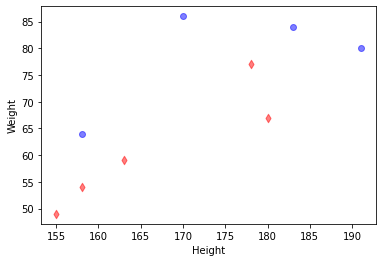

In [37]:
plt.figure()
plt.xlabel('Height')
plt.ylabel('Weight')

for i, x in enumerate(X_train):
    plt.scatter(x[0], x[1], c='b' if y_train[i] == 1 else 'r', marker='o' if y_train[i] == 1 else 'd', alpha=0.5)

In [47]:
tree = generate_kd_tree(X_train, y_train)

In [67]:
for i, x in enumerate(x_test):
    ini_node = search_kd_tree(x, 0, tree)
    k_list = find_k_neighbors_1(x, node=0, k=3, kd_tree=tree)
    y = majority_vote(x, k_list, kd_tree=tree)
    print(f'编号{i}, 特征{x}, 预测为{"男性" if y==1 else "女性"}')

编号0, 特征[168  65], 预测为女性
编号1, 特征[180  96], 预测为男性
编号2, 特征[160  52], 预测为女性
编号3, 特征[169  67], 预测为女性


###  5.2 鸢尾花

In [110]:
from sklearn import datasets

In [111]:
d = datasets.load_iris()

In [112]:
x_labels, y_labels = d['feature_names'], d['target_names']

In [113]:
rand_idx = np.arange(len(d['target']))
np.random.shuffle(rand_idx)

In [114]:
t_idx = rand_idx[:100]
v_idx = rand_idx[100:]

In [115]:
x_train, y_train = d['data'][t_idx], d['target'][t_idx]
x_valid, y_valid = d['data'][v_idx], d['target'][v_idx]

In [116]:
y_train

array([1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 2, 2, 2, 1, 2, 2, 0, 1, 1, 0, 0,
       1, 0, 0, 2, 0, 2, 0, 0, 0, 2, 1, 2, 1, 1, 1, 2, 0, 2, 2, 0, 1, 0,
       2, 2, 2, 1, 2, 1, 0, 2, 0, 0, 0, 0, 1, 2, 1, 0, 1, 2, 0, 1, 1, 0,
       2, 1, 2, 2, 2, 0, 2, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 2, 2, 0, 1, 1, 1, 1, 0, 2])

In [146]:
tree = generate_kd_tree(x_train, y_train)
pred_y = []
for i, x in enumerate(x_valid):
    ini_node = search_kd_tree(x, 0, tree)
    k_list = find_k_neighbors_1(x, node=0, k=1, kd_tree=tree)
    y = majority_vote(x, k_list, kd_tree=tree)
    pred_y.append(y)
#     print(f'编号{i}, 特征{x}, 预测为{y}, 实例为{y_valid[i]}')

pred_y = np.array(pred_y)
np.sum(pred_y==y_valid) / y_valid.size

0.98

In [144]:
k_list

[[0.5099019513592781, 72],
 [0.5196152422706629, 73],
 [0.5385164807134503, 3],
 [0.5477225575051655, 8],
 [0.5744562646538026, 71],
 [0.5830951894845299, 34],
 [0.6, 69]]